In [1]:
type_list = ['EC','pH']
interval_list = [3,6,12,24,36,48]

In [2]:
import torch
from torch import nn, optim
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import r2_score as r2
from sklearn.metrics import mean_absolute_percentage_error

class windowDataset(Dataset):
  def __init__(self, data, window, interval, stride =1):
    # 총 데이터 수
    L = data.shape[0]
    # stride 씩 움직일 때 생기는 데이터의 개수
    num_samples = (L - window - interval) // stride + 1

    # (window크기, sample개수)
    X = np.zeros([window, num_samples])
    Y = np.zeros([interval, num_samples])

    for i in np.arange(num_samples):
      start_x = stride * i
      end_x = start_x + window
      X[:,i] = data[start_x:end_x]

      start_y = stride * i + window
      end_y = start_y + interval
      Y[:,i] = data[start_y:end_y]

    X = X.reshape(X.shape[0], X.shape[1], 1).transpose((1,0,2))
    Y = Y.reshape(Y.shape[0], Y.shape[1], 1).transpose((1,0,2))

    self.x = X
    self.y = Y
    self.len = len(X)

  def __getitem__(self,i):
    return self.x[i], self.y[i]

  def __len__(self):
    return self.len

device = "cuda" if torch.cuda.is_available() else "cpu"


class LSTM(nn.Module):
  def __init__(self, input_size, hidden_size, num_stacked_layers, output_size):
    super().__init__()
    self.hidden_size = hidden_size
    self.num_stacked_layers = num_stacked_layers
    self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size,
                        num_layers = num_stacked_layers, batch_first = True)
    self.linear = nn.Linear(hidden_size, output_size)
  
  def forward(self, x):
    batch_size = x.size(0)
    h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
    c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)

    out, _ = self.lstm(x, (h0, c0))
    out = self.linear(out[:,-1,:])
    return out

def training(loader, device, model, criterion):
  model.train()
  cost = 0.
  for x,y in loader:
    x = x.to(torch.float32).to(device)
    y = y.to(torch.float32).to(device)
    y = y.squeeze(-1)
    output = model(x)
    loss = criterion(output, y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    cost += float(loss)
  cost = cost/len(loader)
  return cost

def evaluation(loader, device, model, criterion):
  model.eval()
  cost = 0.
  for x,y in loader:
    x = x.to(torch.float32).to(device)
    y = y.to(torch.float32).to(device)
    y = y.squeeze(-1)
    output = model(x)
    loss = criterion(output, y)
    cost += float(loss)
  cost = cost/len(loader)
  return cost

def loss_graph_maker(train_loss_list, valid_loss_list, type, interval):
    train_trace = np.array(train_loss_list)
    valid_trace = np.array(valid_loss_list)
    plt.figure(figsize = (15,8))
    plt.plot(train_trace, label = 'train_loss')
    plt.plot(valid_trace, label = 'valid_loss')
    plt.legend(loc = 'best')
    plt.title(f'LSTM {type}({interval}) Loss Graph')
    plt.savefig(f'./graph/{type}/{interval}/LSTM_{type}({interval}).jpeg')

###### EC ######
3
6
12
24
36
48
###### pH ######
3
6
12
24
36
48


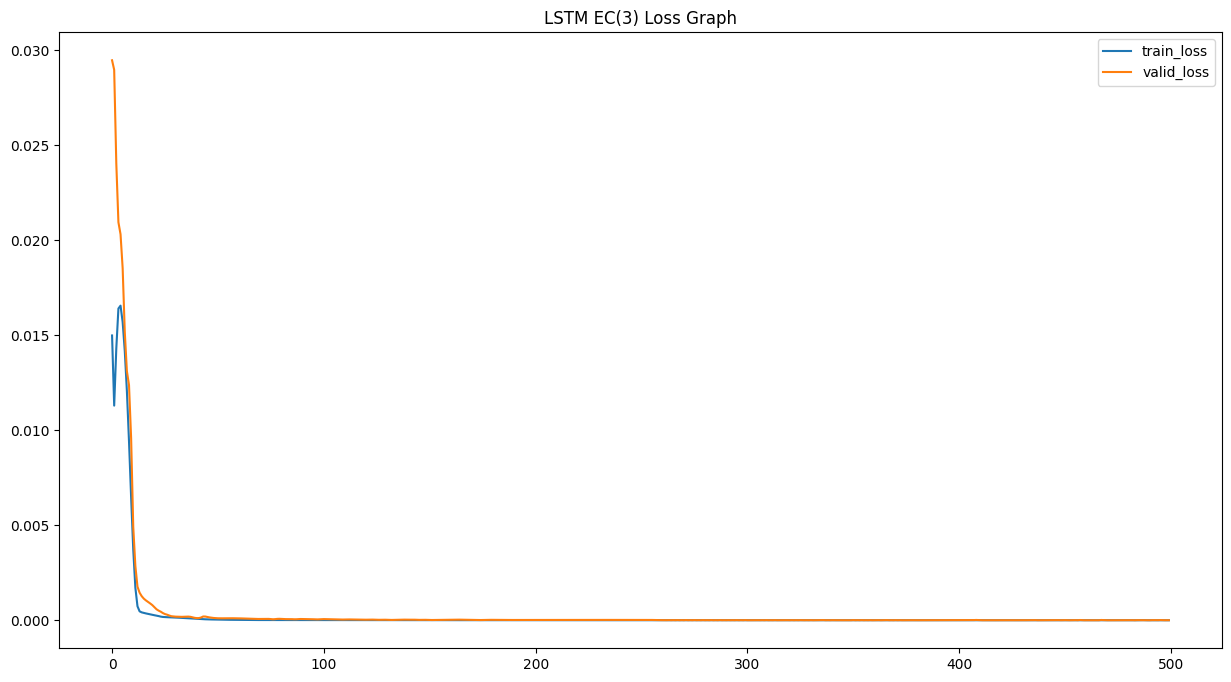

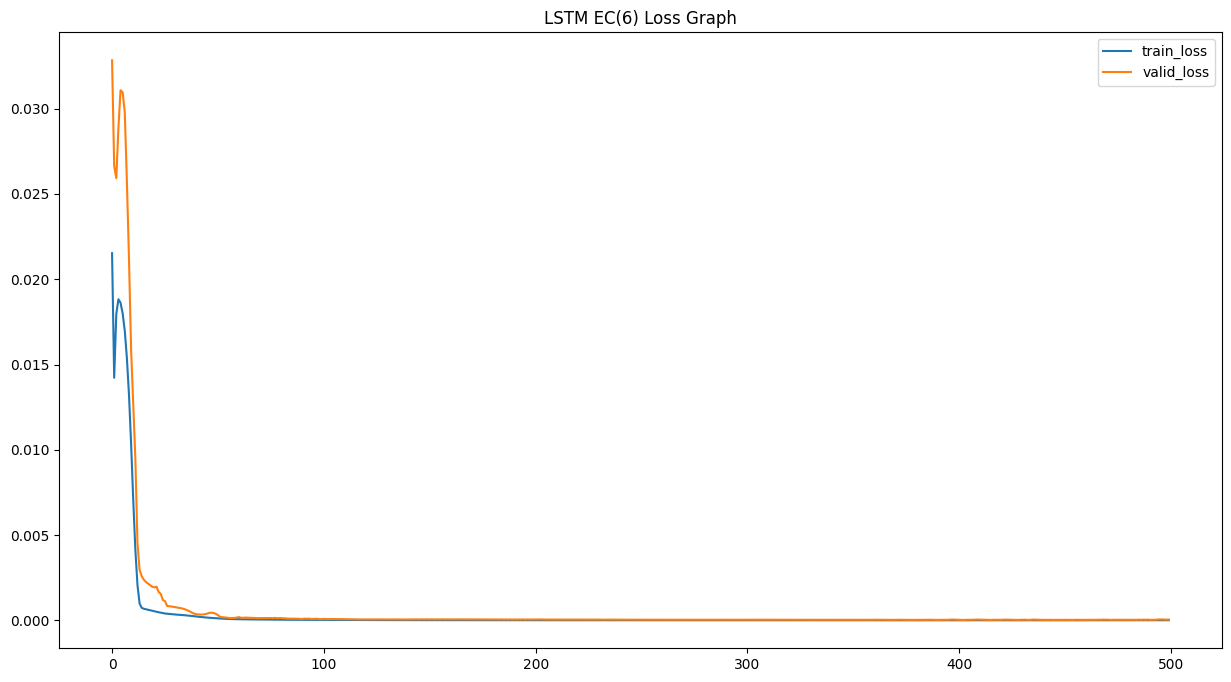

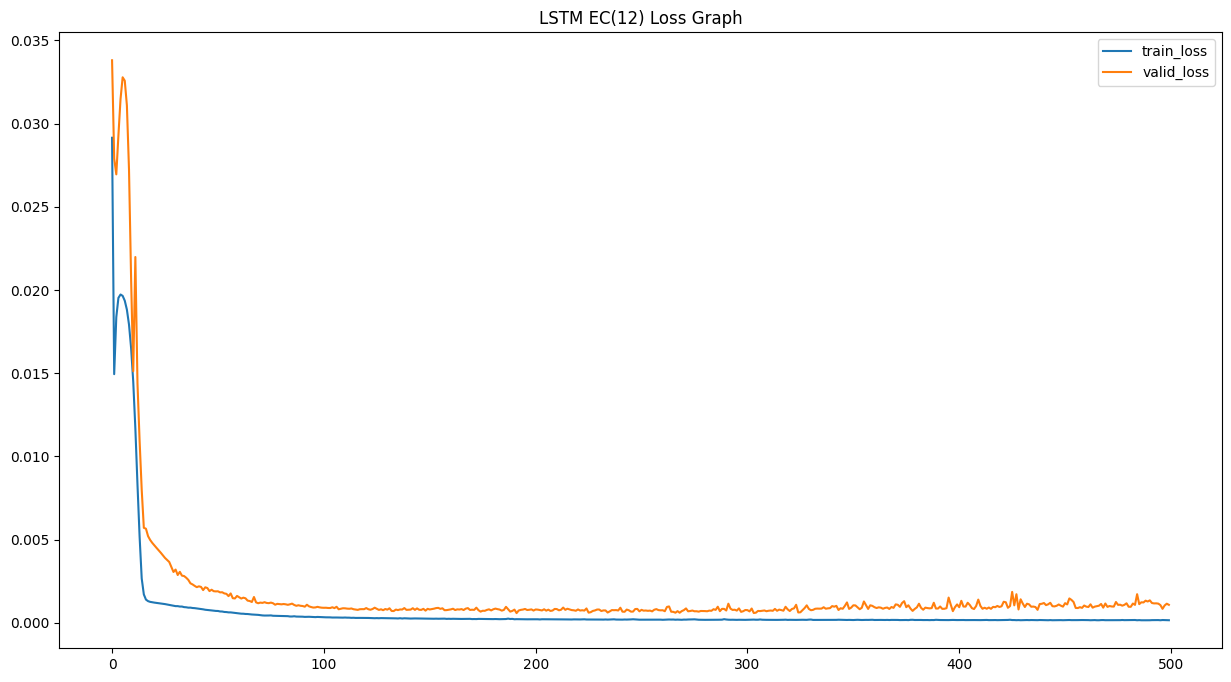

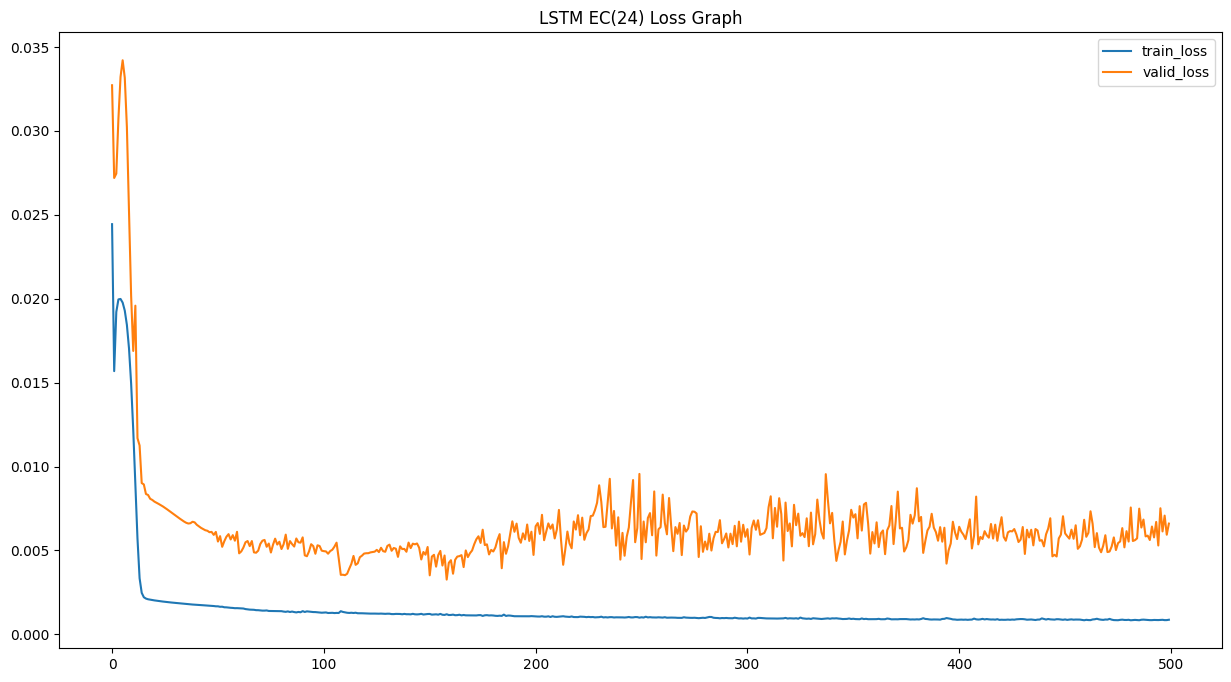

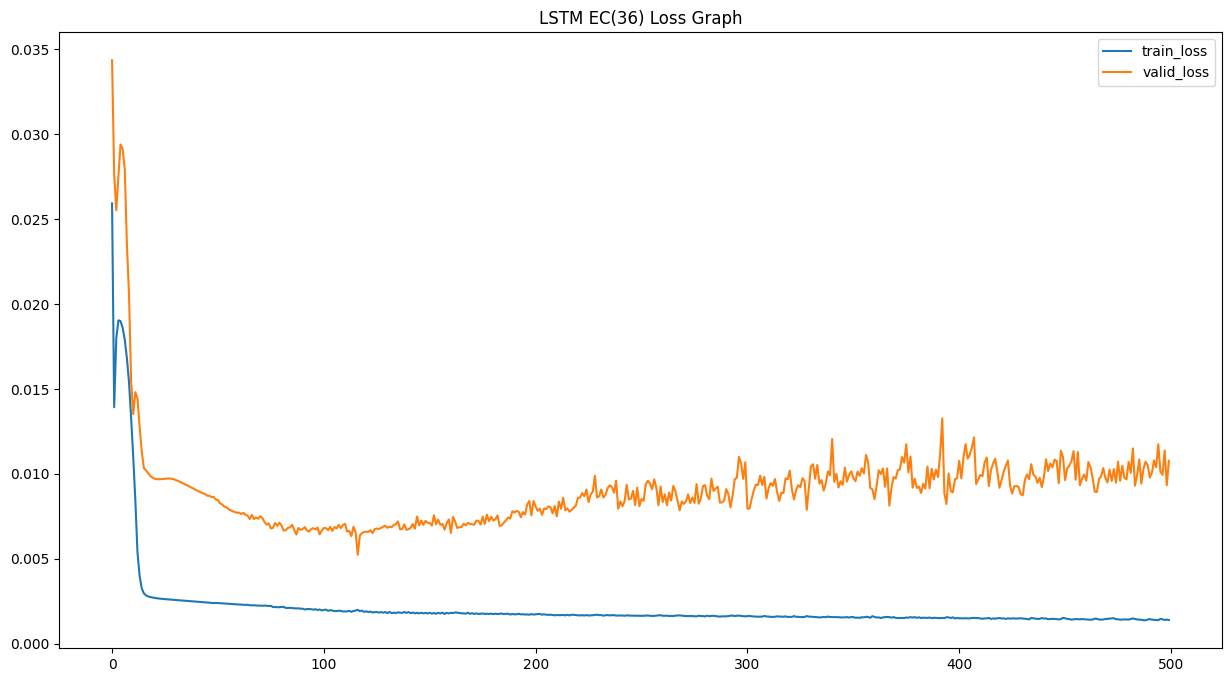

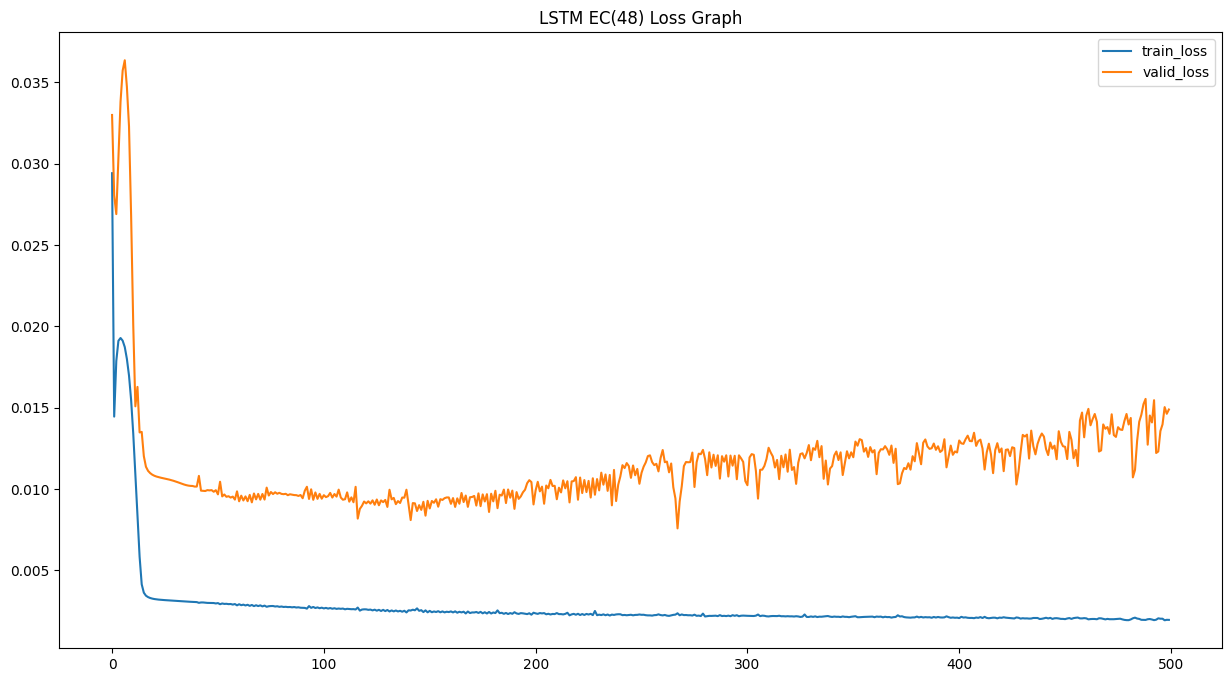

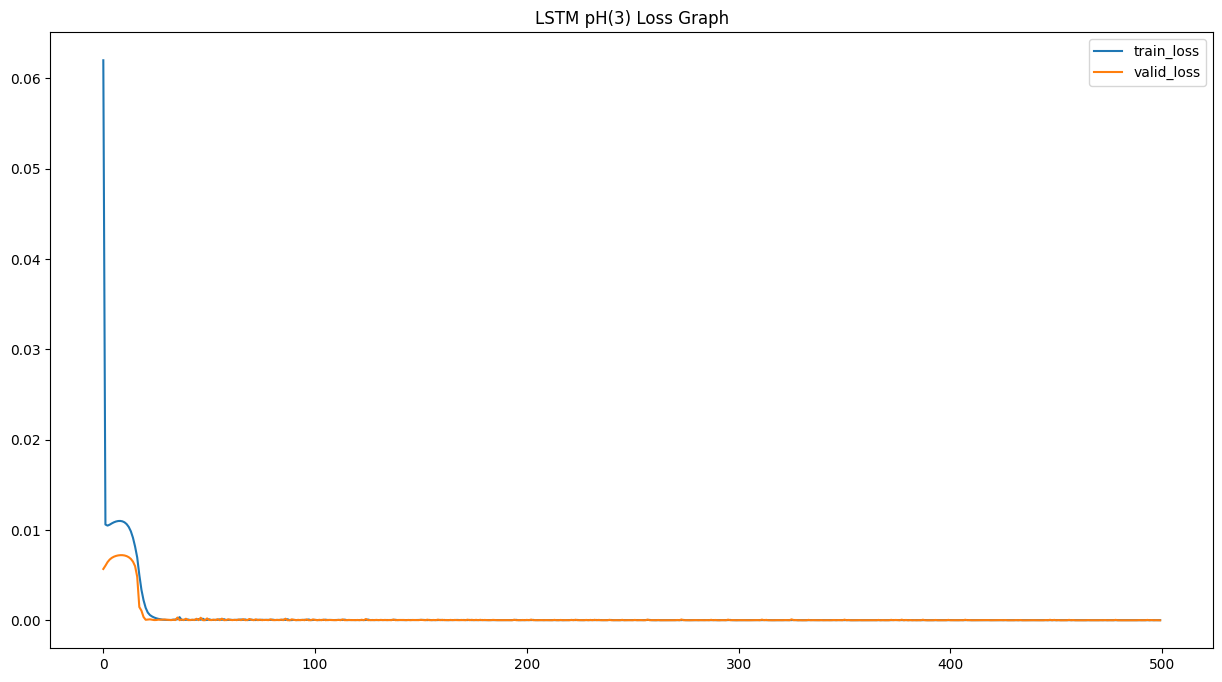

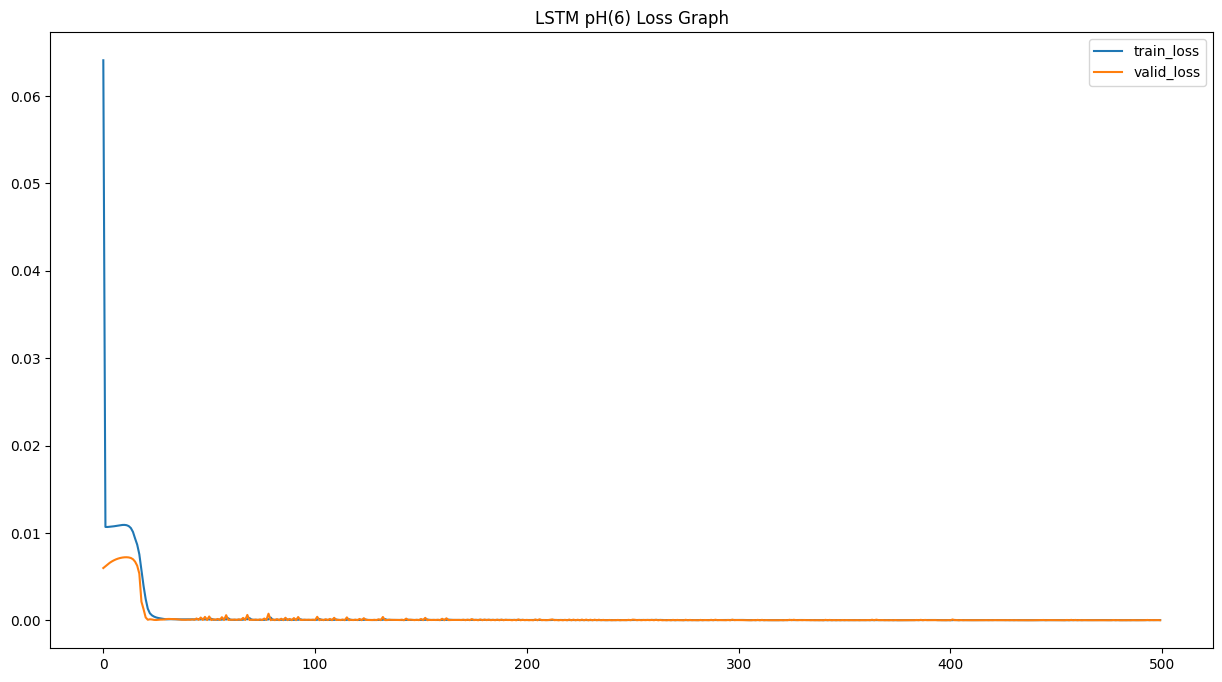

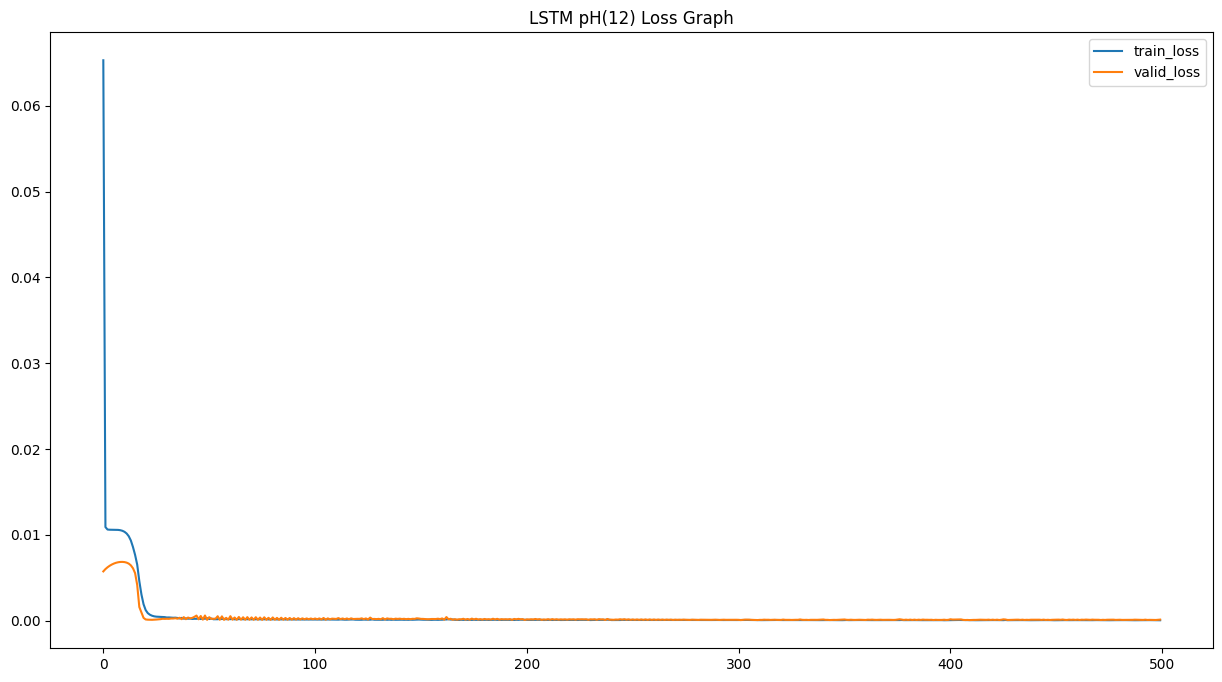

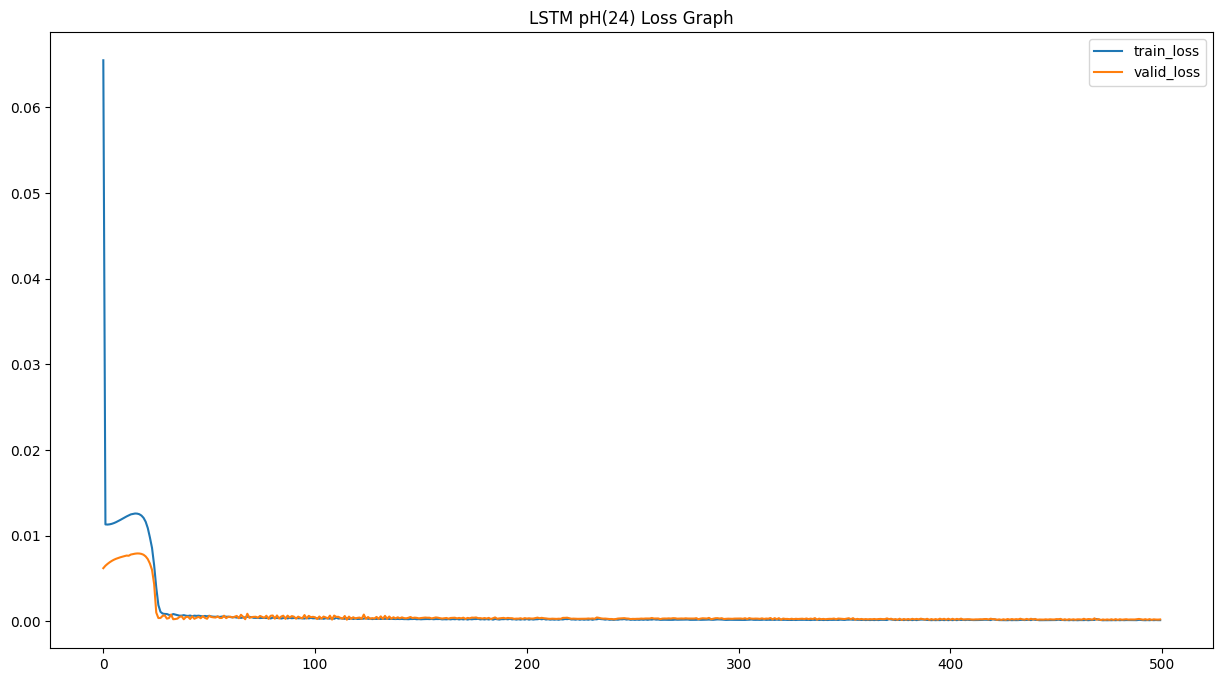

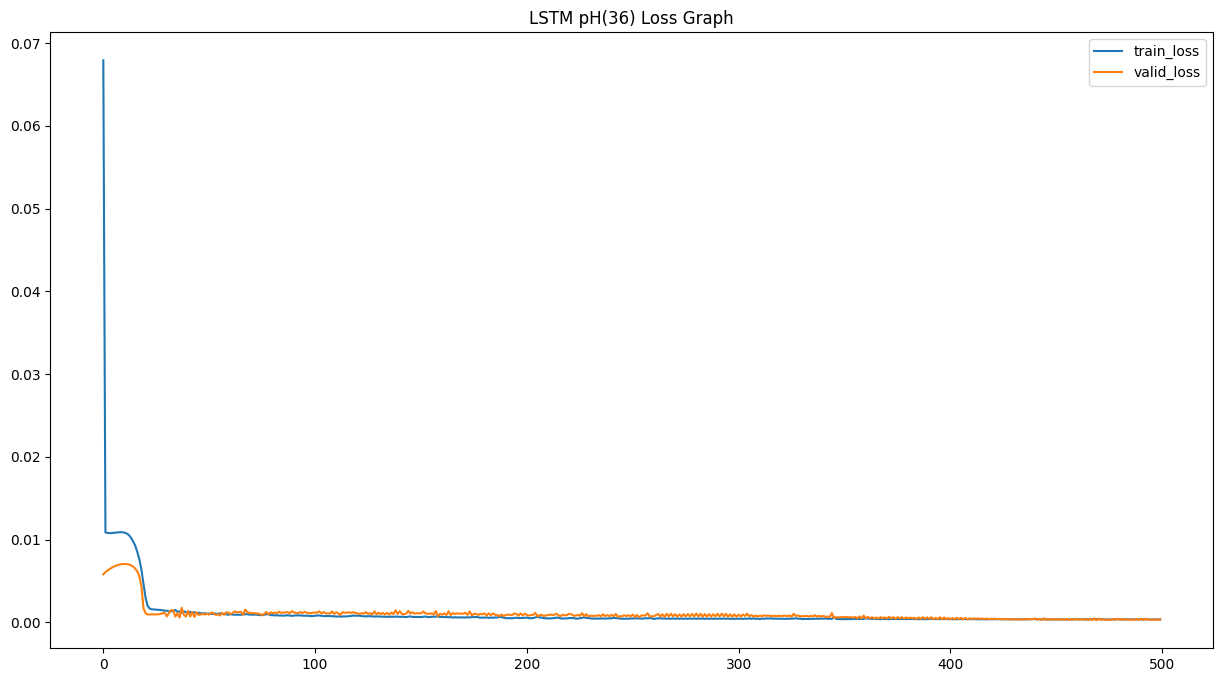

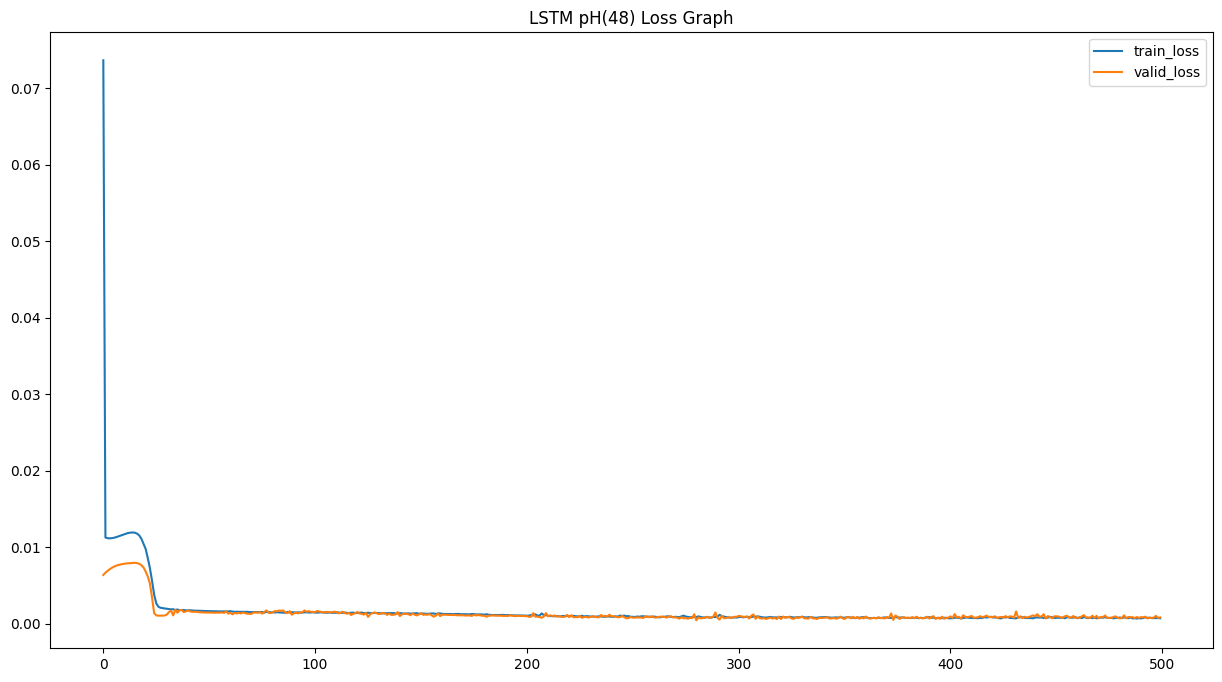

In [3]:
for type in type_list:
    print(f'###### {type} ######')
    EEMD = pd.read_excel('./EEMD1.xlsx', sheet_name = f"{type}")
    EEMD = EEMD[f"{type}_origin"]
    EEMD = np.array(EEMD).reshape(-1,1)
    
    tmp = int(EEMD.shape[0]//5)
    train, valid, test = EEMD[:-tmp*2], EEMD[-tmp*2:-tmp], EEMD[-tmp:]
    
    u, l = train.max(), train.min()

    train, valid, test = (train - l)/(u-l), (valid - l)/(u-l), (test - l)/(u-l)
    window = 24
    for interval in interval_list:
        print(f'{interval}')
        train_dataset = windowDataset(data = train.reshape(-1), window = window, interval = interval, stride = 1)
        valid_dataset = windowDataset(data = valid.reshape(-1), window = window, interval = interval, stride = 1)
        test_dataset = windowDataset(data = test.reshape(-1), window = window, interval = interval, stride = 1)
        train_loader = DataLoader(train_dataset, batch_size = 64, drop_last = True)
        valid_loader = DataLoader(valid_dataset, batch_size = 64, drop_last = True)
        
        model = LSTM(input_size = 1, hidden_size = 25, num_stacked_layers = 2, output_size = interval).to(device)
        lr = 0.001
        epochs = 500
        criterion = nn.MSELoss().to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr = lr)
        train_loss_list = []
        valid_loss_list = []
        
        best_loss = 10
        for epoch in range(epochs):
          train_loss = training(loader = train_loader, device = device, model = model, criterion = criterion)
          valid_loss = evaluation(loader = valid_loader, device = device, model = model, criterion = criterion)
          train_loss_list.append(train_loss)
          valid_loss_list.append(valid_loss)
          if best_loss > valid_loss:
            # best_loss변경
            best_loss = valid_loss
            # 모델의 valid loss가 향상된 경우에만 모델을 저장 == checkpoint
            torch.save(model.state_dict(), f'./model_pt/{type}/{interval}/LSTM_{type}({interval}).pt')
          else:
              pass
        loss_graph_maker(train_loss_list = train_loss_list,
                         valid_loss_list = valid_loss_list,
                         type = type, interval = interval)
        del train_loss
        del valid_loss
        del model
        del criterion
        del train_loader
        del valid_loader
        torch.cuda.empty_cache()